# Analyzing 1-step QAOA on non-triangle-free graphs

This is heavily based on work in https://ui.adsabs.harvard.edu/abs/2018PhRvA..97b2304W/ . 

In their Theorem 1, they prove a formula for $\langle C_{uv} \rangle$, assuming node $u$ has $d_u + 1$ neighbors, node $v$ has $d_v + 1$ neighbors, and there are $\lambda_{uv}$ triangles containing $E_{uv}$.

$$
\langle C_{uv} \rangle = 1/2 + (1/4)sin(4\beta)sin(\gamma)(cos^{d_u}(\gamma) + cos^{d_v}(\gamma)) - (1/4)sin^2(\beta) cos^{d_u + d_v - 2\lambda_{uv}}(\gamma)(1 - cos^{\lambda_{uv}}(2\gamma))
$$

On a D-regular graph, when the subgraphs are identical (assuming $Y$ triangles per subgraph), the number of cut edges is $K = (DN/2) \langle C_{uv}\rangle$. In this case, $\langle C_{uv} \rangle = 1/2 + \delta$:

$$
\delta = (1/2)sin(4\beta)sin(\gamma)cos^{D-1}(\gamma) - (1/4)sin^2(\beta)cos^{2(D-1-Y)}(\gamma)(1-cos^Y(2\gamma))
$$

For QAOA, the angles $(\gamma, \beta)$ are typically optimized to maximize $\delta$.

The triangle-free case is described in their work, finding maximum angles $(\gamma, \beta) = (\arctan(1/\sqrt{D-1}), \pi/8)$. This can be proved by taking $(d\delta/d\gamma)$ and $(d\delta/d\beta)$, respectively. They also find $\delta$:

$$
\delta_{max} = (1/2)D^{-0.5}(1-1/D)^{(D-1)/2} > (1/2)D^{-0.5}e^{-0.5}
$$

The inequality follows because $\sqrt{(1-1/D)^D}$ tends towards $\sqrt{e^{-1}}$. 

---

## Finding maximum angle with triangles

I did not solve this analytically. Instead, I use a grid search over $\gamma$ and $\beta$:

In [1]:
from numpy import sin, cos, linspace, pi, e
import numpy as np
import matplotlib.pyplot as plt

In [478]:
def delta_triangles(beta, gamma, D, Y):
    """This calculates delta, given a D-regular graph with Y triangles related to each edge."""
    t1 = 0.5*sin(4*beta)*sin(gamma)*(cos(gamma)**(D-1))
    t2 = 0.25*(sin(beta)**2)*(cos(gamma)**(2*(D-1-Y)))*(1-(cos(2*gamma)**Y))
    return t1 - t2

In [3]:
def get_max(D, Y, try_optimal_value = False):
    """This searches over beta and gamma to find the optimal value of delta."""
    results = []
    for beta in linspace(0, 2*pi, 128):
        results += [delta_triangles(beta, gamma, D, Y) for gamma in linspace(0, 2*pi, 128)]
        if try_optimal_value:
            # test optimal gamma choice for triangle-free graphs
            results.append(delta_triangles(beta, np.arctan((D-1)**-0.5), d, f))
    return max(results)

### Plots

This search should match the optimal value closely for triangle-free graphs.

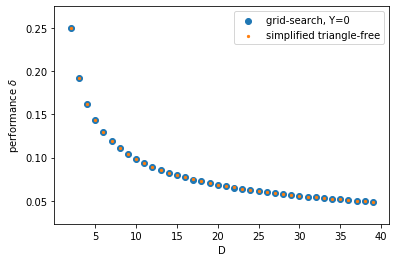

In [4]:
# This compares delta = Cuv - 1/2 from search vs the known optimal value for triangle-free graphs.
Y=0
inputs = range(2, 40)
plt.scatter(inputs, [get_max(D, Y) for D in inputs], label="grid-search, Y=0")
plt.scatter(inputs, [(1 - 1/D)**((D-1)/2) * 1/2 * D**-0.5 for D in inputs], s=5, label="simplified triangle-free")
plt.xlabel("D")
plt.ylabel("performance $\delta$")
plt.legend()

How does this vary with Y? The performance gets worse with more triangles, but not by much.

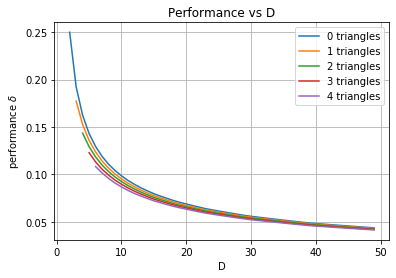

In [5]:
for Y in range(5):
    inputs = range(2+Y, 50)
    plt.plot(inputs, [get_max(D, Y) for D in inputs], label=str(Y) + " triangles")
plt.legend()
plt.title("Performance vs D")
plt.xlabel("D")
plt.ylabel("performance $\delta$")
plt.grid()

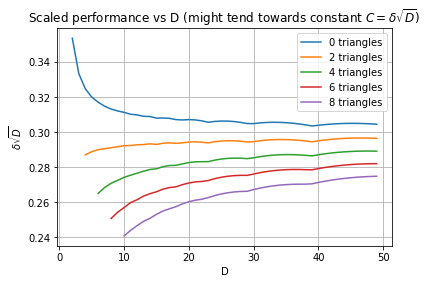

In [6]:
for Y in range(0, 10, 2):
    inputs = range(2+Y, 50)
    plt.plot(inputs, [get_max(D, Y)*(D**0.5) for D in inputs], label=str(Y) + " triangles")
plt.legend()
plt.title("Scaled performance vs D (might tend towards constant $C = \delta \sqrt{D}$)")
plt.xlabel("D")
plt.ylabel("$\delta \sqrt{D}$")
plt.legend()
plt.grid(True)

---

# Analyzing 2-step QAOA on girth > 5 graphs

The chance of including an edge in MAXCUT can be written as 

$$
\langle C_{uv} \rangle_2 
= Tr[\rho_0 e^{i\gamma_1 C} e^{i\beta_1 J} e^{i\gamma_2 C} e^{i\beta_2 J} 
C_{uv}
e^{-i\beta_2 J} e^{-i\gamma_2 C} e^{-i\beta_1 J} e^{-i\gamma_1 C} ]
$$

with the following definitions on a graph $(V,E)$:
* $\rho_0 = \otimes_{i} (I/2 + \sigma_i^x/2) $ is the uniform superposition over all states
* $\gamma_1, \beta_1, \gamma_2, \beta_2$ are the chosen "angles"
* $C_{uv} = 1/2 - \sigma_u^z \sigma_v^z / 2$ is 1 iff the edge is cut (i.e. the nodes differ in spin)
* $C = \sum_{(u,v) \in E} C_{uv}$ is the sum of all $C_{uv}$ where there exists an edge from $u$ to $v$
* $J = \sum_{j \in V} \sigma_j^x$ is the mixing defined by QAOA

This analysis follows the approach given in Appendix A of https://ui.adsabs.harvard.edu/abs/2018PhRvA..97b2304W/ . We will assume a graph is D-regular, triangle and square and pentagon free (i.e. girth > 5).

Simplifying,
$$
\langle C_{uv} \rangle_2 
= 0.5 - 0.5 Tr[\rho_0 e^{i\gamma_1 C} e^{i\beta_1 J} e^{i\gamma_2 C}
\Big(c^2 \sigma_u^z \sigma_v^z + sc(\sigma_u^y \sigma_v^z + \sigma_u^z \sigma_v^y) + s^2 \sigma_u^y \sigma_v^y \Big)
e^{-i\gamma_2 C} e^{-i\beta_1 J} e^{-i\gamma_1 C} ]
$$

where $c = cos(2\beta_2)$ and $s = sin(2\beta_2)$.

Let's compute each term of the inner expression separately. We will then calculate $\langle C_{uv} \rangle_2 = 1/2 - 1/2 (A + B + C + E)$.

## Calculating A

Since $C$ commutes with $\sigma_u^z\sigma_v^z$, $A$ will look very similar to the result $\langle C_{uv} \rangle_1$. Given a D-regular, triangle-free graph:

$$
A/c^2 = -sin(4\beta_1)sin(\gamma_1)cos^{D-1}(\gamma_1)
$$

## Calculating E

The only terms of $C$ that anticommute with $\sigma_u^y \sigma_v^y$ are the other $D-1$ neighbors of $u$ and $v$. 

$$
E/s^2 = Tr[\rho_0 e^{i\gamma_1 C} e^{i\beta_1 J}
\big( \prod_{i=1}^{D-1} e^{-i \gamma_2 \sigma_u^z \sigma_{w_i}^z} \big) 
\big( \prod_{j=1}^{D-1} e^{-i \gamma_2 \sigma_v^z \sigma_{\chi_j}^z} \big) 
 \sigma_u^y \sigma_v^y
e^{-i\beta_1 J} e^{-i\gamma_1 C} ]
$$

The only terms of $J$ that do not commute with the inner expression reference the nodes $u, v, w_1, ..., w_{D-1}, \chi_1, ..., \chi_{D-1}$.

$$
E/s^2 = Tr[\rho_0 e^{i\gamma_1 C} 
e^{i\beta_1 \sigma_u^x}
e^{i\beta_1 \sigma_v^x}
\big( \prod_{i=1}^{D-1} 
    e^{i\beta_1 \sigma_{w_i}^x} 
    e^{-i \gamma_2 \sigma_u^z \sigma_{w_i}^z} 
    e^{-i\beta_1 \sigma_{w_i}^x}\big) 
\big( \prod_{j=1}^{D-1} 
    e^{i\beta_1 \sigma_{\chi_j}^x} 
    e^{-i \gamma_2 \sigma_v^z \sigma_{\chi_j}^z} 
        e^{-i\beta_1 \sigma_{\chi_j}^x}\big) 
e^{i\beta_1 \sigma_u^x}
e^{i\beta_1 \sigma_v^x}
 \sigma_u^y \sigma_v^y
e^{-i\gamma_1 C} ]
$$

The inner expressions can be simplified.
*  Let $m = cos(\gamma_2)$ and $n = sin(\gamma_2)$:

$$
e^{i \beta_1 \sigma_{w_i}^x}  e^{-i \gamma_2 \sigma_u^z \sigma_{w_i}^z} e^{-i\beta_1 \sigma_{w_i}^x}
 = e^{i \beta_1 \sigma_{w_i}^x} (m - in \sigma_u^z \sigma_{w_i}^z) e^{-i \beta_1 \sigma_{w_i}^x}
 = m - in e^{2 i \beta_1 \sigma_{w_i}^x}\sigma_u^z \sigma_{w_i}^z
$$

$$
E/s^2 = Tr[\rho_0 e^{i\gamma_1 C} 
e^{i\beta_1 \sigma_u^x}
e^{i\beta_1 \sigma_v^x}
\big( \prod_{i=1}^{D-1} 
m - in e^{2 i \beta_1 \sigma_{w_i}^x}\sigma_u^z \sigma_{w_i}^z
\big) 
\big( \prod_{j=1}^{D-1} 
m - in e^{2 i \beta_1 \sigma_{\chi_j}^x}\sigma_v^z \sigma_{\chi_j}^z
\big) 
e^{i\beta_1 \sigma_u^x}
e^{i\beta_1 \sigma_v^x}
 \sigma_u^y \sigma_v^y
e^{-i\gamma_1 C} ]
$$

The only terms of $C$ that may not commute involve edges connected to a node in $R = \{u, v, w_1, ..., w_{D-1}, \chi_1, ..., \chi_{D-1}\}$. Since the graph has girth > 5, each of their neighbors are distinct. 

* Let $p = cos(\gamma_1 / 2)$ and $q = sin(\gamma_1 / 2)$.

The trace is nonzero for terms that are proportional to $I$ or $\sigma_n^x$ for all nodes $n$. Terms of $e^{i\gamma_1 C}$ that connect $j$ and $k$ have the form $p - iq \sigma_j^z \sigma_k^z$. 

There are $2(D-1)(D-1)$ edges where $j\in R$ but $k \notin R$. **For now, ignore these terms and we will come back to it later.**

$$
E/s^2 =  
Tr[ \rho_0 
(p - iq \sigma_u^z \sigma_v^z)
\big( \prod_{i=1}^{D-1} (p - iq \sigma_u^z \sigma_{w_i}^z) \big)
\big( \prod_{j=1}^{D-1} (p - iq \sigma_v^z \sigma_{\chi_j}^z) \big)
$$
$$
e^{i\beta_1 \sigma_u^x}
e^{i\beta_1 \sigma_v^x}
\big( \prod_{i=1}^{D-1} 
m - in e^{2 i \beta_1 \sigma_{w_i}^x}\sigma_u^z \sigma_{w_i}^z
\big) 
\big( \prod_{j=1}^{D-1} 
m - in e^{2 i \beta_1 \sigma_{\chi_j}^x}\sigma_v^z \sigma_{\chi_j}^z
\big) 
e^{i\beta_1 \sigma_u^x}
e^{i\beta_1 \sigma_v^x}
$$
$$
(p + iq \sigma_u^z \sigma_v^z)
\big( \prod_{i=1}^{D-1} (p - iq \sigma_u^z \sigma_{w_i}^z) \big)
\big( \prod_{j=1}^{D-1} (p - iq \sigma_v^z \sigma_{\chi_j}^z) \big)
\sigma_u^y \sigma_v^y
]
$$

All $\sigma_z$ and $\sigma_y$ must be cancelled out or converted to $\sigma_x$. 

Consider the $\sigma_u^y \sigma_v^y$. This can only be cancelled with $(p \pm iq \sigma_u^z \sigma_v^z)$, since other terms include additional $\sigma_{w_i}^z$ or $\sigma_{\chi_j}^z$ which cannot be cancelled out alone.

The only allowed terms from $(p - iq \sigma_u^z \sigma_v^z) \cdots (p + iq \sigma_u^z \sigma_v^z) \sigma_u^y \sigma_v^y$ are as follows:
1. $(p)\cdots(iq\sigma_u^z \sigma_v^z) \sigma_u^y \sigma_v^y \to -ipq$
2. $(-iq\sigma_u^z \sigma_v^z)\cdots(p)\sigma_u^y \sigma_v^y \to ipq$, where all $e^{i\beta_1 \sigma_u^x}e^{i\beta_1 \sigma_v^x} \to e^{-i\beta_1 \sigma_u^x}e^{-i\beta_1 \sigma_v^x}$

* Let $k = cos(\beta_1)$ and $l = sin(\beta_1)$.

Summing these two terms converts the mentioned exponentials to 
$$
2pqkl(k^2 - l^2 \sigma_u^x \sigma_v^x) \cdots (\sigma_u^x + \sigma_v^x)
$$
plus the terms reversed:
$$
2pqkl (\sigma_u^x + \sigma_v^x)\cdots(k^2 - l^2 \sigma_u^x \sigma_v^x)
$$

Of the expressions that include $\sigma_{w_i}^z$, only half include an even number. Only these corresponding terms will contribute to trace. Note that each of these terms includes an even number of $\sigma_u^z$.

$$
(p - iq \sigma_u^z \sigma_{w_i}^z)
 \cdots (m - in e^{2 i \beta_1 \sigma_{w_i}^x}\sigma_u^z \sigma_{w_i}^z)
\cdots (p - iq \sigma_u^z \sigma_{w_i}^z)
$$

1. $(p, m, p) \to W_1 = mp^2$
2. $(p, - in e^{2 i \beta_1 \sigma_{w_i}^x}\sigma_u^z \sigma_{w_i}^z, - iq \sigma_u^z \sigma_{w_i}^z) \to W_2 = -npqe^{2 i \beta_1 \sigma_{w_i}^x}$
3. $(- iq \sigma_u^z \sigma_{w_i}^z, m, - iq \sigma_u^z \sigma_{w_i}^z) \to W_3 = -mq^2$
4. $( - iq \sigma_u^z \sigma_{w_i}^z, - in e^{2 i \beta_1 \sigma_{w_i}^x}\sigma_u^z \sigma_{w_i}^z, p) \to W_4 = -npq e^{-2 i \beta_1 \sigma_{w_i}^x}$


In the above terms, sometimes the exponential sign flips when commuting with $\sigma^z$.

The same thing happens for any $\sigma_{\chi_j}^z$.

Any $\sigma_u^z$ that crosses $(\sigma_u^x + \sigma_v^x)$ to cancel out will not contribute to trace.

* Let $r = k^2 - l^2 = cos(2 \beta_1)$ and $t = 2kl = sin(2 \beta_1)$.
* Let $G = p^2 - q^2 = cos(\gamma_1)$ and $H = 2pq = sin(\gamma_1)$.

Then:

$$
E/(s^2 2pqkl) = 2 \big( W_1(k^2 - l^2) + W_4(k^2 + l^2) \big)^{2(D-1)} + 2 \big( W_1(k^2 - l^2) + W_2(k^2 + l^2) \big)^{2(D-1)} = 2(r W_1 + W_4)^{2D-2} + 2(r W_1 + W_2)^{2D-2}
$$

$$
E/(s^2 tH) = (mp^2 r - npq e^{-2i\beta_1})^{2D-2} + (mp^2 r - npq e^{2i \beta_1 })^{2D-2}
$$

$$
E/(s^2 tH) = ((mp^2 -npq) r + it)^{2D-2} + ((mp^2 -npq) r - it)^{2D-2}
$$

$$
E/(s^2 tH) = (1/2 (mr + mGr -nHr) + it)^{2D-2} + (1/2 (mr + mGr -nHr) - it)^{2D-2}
$$

Now consider the crossover terms $(p + iq \sigma_j^z \sigma_k^z)$ where $j \in R$, $k \notin R$. You need to include an even number of $\sigma_k^z$. Including the $\sigma_k^z$ ultimately swaps $W_2$ for $W_4$. This swaps $it$ for $-it$, so $it \to iGt$. This happens $D-1$ times, for each of the $2D-2$ terms listed.

$$
E/(s^2 tH) = (1/2 (mr + mGr -nHr) + iG^{D-1}t)^{2D-2} + (1/2 (mr + mGr -nHr) - iG^{D-1}t)^{2D-2}
$$

## Calculating B and C

### Simplifying

Since the graph is identical from $u$ and $v$'s perspective, $B = C$.

$$
B/sc = Tr[\rho_0 e^{i\gamma_1 C} e^{i\beta_1 J} e^{i\gamma_2 C}
\sigma_u^y \sigma_v^z 
e^{-i\gamma_2 C} e^{-i\beta_1 J} e^{-i\gamma_1 C} ]
$$

The only anti-commuting terms of $C$ and $\sigma_u^y \sigma_v^z$ any edges $w_1, ... w_{D-1}, v$ connected to $u$.
$$
B/sc = Tr[\rho_0 e^{i\gamma_1 C} e^{i\beta_1 J}
\big( \prod_{i=1}^{D-1} e^{-i \gamma_2 \sigma_u^z \sigma_{w_i}^z} \big) 
e^{-i \gamma_2 \sigma_u^z \sigma_v^z}
\sigma_u^y \sigma_v^z 
 e^{-i\beta_1 J} e^{-i\gamma_1 C} ]
$$

The only terms of $J$ that do not commute with the inner expression reference the nodes $u, v, w_1, ..., w_{D-1}$.

$$
B/sc = Tr[\rho_0 e^{i\gamma_1 C}
e^{i\beta_1 \sigma_u^x}
\big( \prod_{i=1}^{D-1} 
  e^{i\beta_1 \sigma_{w_i}^x} 
  e^{-i \gamma_2 \sigma_u^z \sigma_{w_i}^z}
  e^{-i\beta_1 \sigma_{w_i}^x} 
\big) 
\big(  e^{i\beta_1 \sigma_v^x} e^{-i \gamma_2 \sigma_u^z \sigma_v^z}  
  e^{i\beta_1 \sigma_v^x} \big)
e^{i\beta_1 \sigma_u^x} 
\sigma_u^y \sigma_v^z 
e^{-i\gamma_1 C} ]
$$

The inner expressions can be simplified.
*  Let $m = cos(\gamma_2)$ and $n = sin(\gamma_2)$:

$$
e^{i \beta_1 \sigma_{w_i}^x}  e^{-i \gamma_2 \sigma_u^z \sigma_{w_i}^z} e^{-i\beta_1 \sigma_{w_i}^x}
 = e^{i \beta_1 \sigma_{w_i}^x} (m - in \sigma_u^z \sigma_{w_i}^z) e^{-i \beta_1 \sigma_{w_i}^x}
 = m - in e^{2 i \beta_1 \sigma_{w_i}^x}\sigma_u^z \sigma_{w_i}^z
$$

$$
e^{i \beta_1 \sigma_{v}^x}  e^{-i \gamma_2 \sigma_u^z \sigma_{v}^z} e^{i\beta_1 \sigma_{v}^x}
 = e^{i \beta_1 \sigma_{v}^x} (m - in \sigma_u^z \sigma_{v}^z) e^{i \beta_1 \sigma_{v}^x}
 = e^{2 i \beta_1 \sigma_{v}^x}m - in \sigma_u^z \sigma_{v}^z
$$

$$
B/sc = Tr[\rho_0 e^{i\gamma_1 C}
e^{i\beta_1 \sigma_u^x}
\big( \prod_{i=1}^{D-1} m - in e^{2 i \beta_1 \sigma_{w_i}^x}\sigma_u^z \sigma_{w_i}^z \big) 
\big(  e^{2 i \beta_1 \sigma_{v}^x}m - in \sigma_u^z \sigma_{v}^z \big)
e^{i\beta_1 \sigma_u^x} 
\sigma_u^y \sigma_v^z 
e^{-i\gamma_1 C} ]
$$

The only terms of $C$ that may not commute involve edges connected to a node in $S = \{u, v, w_1, ..., w_{D-1}\}$. Since the graph is triangle and square free, each of their neighbors are distinct. 

* Let $p = cos(\gamma_1 / 2)$ and $q = sin(\gamma_1 / 2)$.

The trace is nonzero for terms that are proportional to $I$ or $\sigma_n^x$ for all nodes $n$. Terms of $e^{i\gamma_1 C}$ that connect $j$ and $k$ have the form $p - iq \sigma_j^z \sigma_k^z$. 

There are $D(D-1)$ edges where $j\in S$ but $k \notin S$. **For now, ignore these terms and we will come back to it later.**

$$
B/sc =  
Tr[ \rho_0 
(p - iq \sigma_u^z \sigma_v^z)
\big( \prod_{i=1}^{D-1} (p - iq \sigma_u^z \sigma_{w_i}^z) \big)
$$
$$
e^{i\beta_1 \sigma_u^x}
\big( \prod_{i=1}^{D-1} (m - in e^{2 i \beta_1 \sigma_{w_i}^x}\sigma_u^z \sigma_{w_i}^z) \big) 
\big(  e^{2 i \beta_1 \sigma_{v}^x}m - in \sigma_u^z \sigma_{v}^z \big)
e^{i\beta_1 \sigma_u^x} 
$$
$$
(p - iq \sigma_u^z \sigma_v^z)
\big( \prod_{i=1}^{D-1} (p - iq \sigma_u^z \sigma_{w_i}^z) \big) \sigma_u^y \sigma_v^z
]
$$

There are a total of $2*2^{D-1}*2*2^{D-1}*2*2*2*2^{D-1} = 2^{3D+2}$ terms that differ in combinations of $\sigma_y$ and $\sigma_z$. But many of them do not contribute to trace.

### Computing each term

Of the expressions that include $\sigma_v^z$, only half include an even number of $\sigma_v^z$. Only these corresponding terms will contribute to trace, since $(\sigma_v^z)^2 = I_z$. Note that each of these terms includes an odd number of $\sigma_u^z$.

$$
(p - iq \sigma_u^z \sigma_v^z) \cdots (e^{2 i \beta_1 \sigma_{v}^x}m - in \sigma_u^z \sigma_{v}^z)
\cdots (p - iq \sigma_u^z \sigma_v^z) \sigma_v^z
$$

1. $(-iq \sigma_u^z \sigma_v^z, e^{2 i \beta_1 \sigma_{v}^x}m , p\sigma_v^z) \to V_1 =  -impqe^{-2i\beta_1 \sigma_{v}^x}$
2. $(p, - in \sigma_u^z \sigma_{v}^z , p\sigma_v^z) \to V_2 =  -inp^2$
3. $(p, e^{2 i \beta_1 \sigma_{v}^x}m, -iq \sigma_u^z \sigma_v^z\sigma_v^z) \to V_3 = -impqe^{2i\beta_1 \sigma_{v}^x}$
4. $(-iq \sigma_u^z \sigma_v^z, - in \sigma_u^z \sigma_{v}^z , -iq \sigma_u^z \sigma_v^z\sigma_v^z) \to V_4 = inq^2$


Similarly, of the expressions that include $\sigma_{w_i}^z$, only half include an even number. Only these corresponding terms will contribute to trace. Note that each of these terms includes an even number of $\sigma_u^z$.

$$
(p - iq \sigma_u^z \sigma_{w_i}^z)
 \cdots (m - in e^{2 i \beta_1 \sigma_{w_i}^x}\sigma_u^z \sigma_{w_i}^z)
\cdots (p - iq \sigma_u^z \sigma_{w_i}^z)
$$

1. $(p, m, p) \to W_1 = mp^2$
2. $(p, - in e^{2 i \beta_1 \sigma_{w_i}^x}\sigma_u^z \sigma_{w_i}^z, - iq \sigma_u^z \sigma_{w_i}^z) \to W_2 = -npqe^{2 i \beta_1 \sigma_{w_i}^x}$
3. $(- iq \sigma_u^z \sigma_{w_i}^z, m, - iq \sigma_u^z \sigma_{w_i}^z) \to W_3 = -mq^2$
4. $( - iq \sigma_u^z \sigma_{w_i}^z, - in e^{2 i \beta_1 \sigma_{w_i}^x}\sigma_u^z \sigma_{w_i}^z, p) \to W_4 = -npq e^{-2 i \beta_1 \sigma_{w_i}^x}$


In the above terms, sometimes the exponential sign flips when commuting with $\sigma^z$.

* Let $k = cos(\beta_1)$ and $l = sin(\beta_1)$.

The last step is to consider the expression $e^{i\beta_1 \sigma_u^x} = k + il \sigma_u^x$. Each combination of terms is matched with its contribution to trace.

1. $(k, k) \to Tr[(k)(k)(V_1 + V_2 + V_3 + V_4)(W_1 + W_2 + W_3 + W_4)^{D-1}\sigma_u^z\sigma_u^y ]$
2. $(k, l) \to Tr[(k)(-il)(V_1 + V_2 - V_3 - V_4)(W_1 - W_2 - W_3 + W_4)^{D-1}\sigma_u^z\sigma_u^y ]$
3. $(l, k) \to Tr[(il)(k)(-V_1 + V_2 + V_3 - V_4)(W_1 + W_2 - W_3 - W_4)^{D-1}\sigma_u^z\sigma_u^y]$
4. $(l, l) \to Tr[(il)(-il)(-V_1 + V_2 - V_3 + V_4)(W_1 - W_2 + W_3 - W_4)^{D-1}\sigma_u^z\sigma_u^y]$


If the first expression $e^{i\beta_1 \sigma_u^x}$ includes $il\sigma_u^x$, it will flip the sign of $V_1, V_4, W_3, W_4$ because of the presence of $\sigma_u^z$.

If the second expression $e^{i\beta_1 \sigma_u^x}$ includes $il\sigma_u^x$, it will flip the sign of $V_3, V_4, W_2, W_4$ because of the presence of $\sigma_u^z$, and the overall sign flips when commuting with $\sigma_u^y$. 

When evaluating the trace, notice that any $V_i W_j$ will include an odd number of $\sigma_u^z$, which combined with $\sigma_u^y$ will add a factor of $-i$ to each term in the trace. Any expressions using $e^{ia \sigma^x}$ can be written as $e^{ia}$. 

The $V$ and $W$ sums can then be simplified.
* Let $r = k^2 - l^2 = cos(2 \beta_1)$ and $t = 2kl = sin(2 \beta_1)$.
* Let $G = p^2 - q^2 = cos(\gamma_1)$ and $H = 2pq = sin(\gamma_1)$.

Here are the $V$ sums:

$$
V_1 + V_2 + V_3 + V_4 
= -impqe^{-2i\beta_1 } + -inp^2 + -impqe^{2i\beta_1 } + inq^2 
=  -impq(2r) - in(p^2 - q^2) = -imrH - inG
$$

$$
V_1 + V_2 - V_3 - V_4 
= -impqe^{-2i\beta_1 } + -inp^2 - -impqe^{2i\beta_1 } - inq^2
= impq(2it) -in(p^2 + q^2) = -mtH - in
$$

$$
-V_1 + V_2 + V_3 - V_4 
= - -impqe^{-2i\beta_1 } + -inp^2 + -impqe^{2i\beta_1 } - inq^2 
= -impq(2it) - in(p^2 + q^2) = mtH - in
$$

$$
-V_1 + V_2 - V_3 + V_4 
= - -impqe^{-2i\beta_1 } + -inp^2 - -impqe^{2i\beta_1 } + inq^2 
= impq(2r) -in(p^2 - q^2) = imrH -inG
$$

Here are the $W$ sums:

$$
W_1 + W_2 + W_3 + W_4 
= mp^2 + -npqe^{2i \beta_1} + -mq^2 + -npqe^{-2i \beta_1}
= m(p^2 - q^2) - npq(2r) = mG - nrH
$$

$$
W_1 - W_2 - W_3 + W_4 
= mp^2 - -npqe^{2i \beta_1} - -mq^2 + -npqe^{-2i \beta_1}
= m(p^2 + q^2) + npq(2it) = m + intH 
$$

$$
W_1 + W_2 - W_3 - W_4 
= mp^2 + -npqe^{2i \beta_1} - -mq^2 - -npqe^{-2i \beta_1}
= m(p^2 + q^2) -npq(2it) = m - intH
$$

$$
W_1 - W_2 + W_3 - W_4 
= mp^2 - -npqe^{2i \beta_1} + -mq^2 - -npqe^{-2i \beta_1}
= m(p^2 - q^2) + npq(2r) = mG + nrH
$$

### Final expression

So, we can sum all terms:

$$
B/sc =  (-i)
$$
$$
\big( k^2 (-i)(mrH + nG)(mG - nrH)^{D-1} +
$$
$$
-ikl (-mtH -in)(m + intH)^{(D-1)} +
$$
$$
ikl (mtH - in)(m - intH )^{(D-1)} +
$$
$$
l^2 (i) (mrH - nG)(mG + nrH)^{D-1} \big)
$$


In a simplified form,
$$
B/sc =0.5 
$$
$$
\big( (1+r)(-mrH - nG)(mG - nrH)^{D-1} +
$$
$$
t(mtH + in)(m + intH)^{(D-1)} +
$$
$$
t (mtH - in)(m - intH)^{(D-1)} +
$$
$$
(1-r) (mrH - nG)(mG + nrH)^{D-1} \big)
$$


### Crossover terms

For edges that introduced a new node $k$, the associated $\sigma_z^k$ must be cancelled. So, the above expression is modified by 
$$
Tr[(p - iq \sigma_j^z \sigma_k^z) \cdots (p + iq \sigma_j^z \sigma_k^z)] = p^2 Tr[\cdots] + q^2 [\sigma_j^z \cdots \sigma_j^z]
$$

For $j=v$, the only term that does not commute with $\sigma_v^z$ is $e^{2 i \beta_1 \sigma_{v}^x} m \to e^{-2 i \beta_1 \sigma_{v}^x} m $. This swaps $V_1$ and $V_3$, which only adjusts $mtH \to -mtH$ in the 2nd and 3rd term of the above expression. Thus, $mtH \to (p^2 - q^2) mtH = mtGH$. All other terms are $T \to (p^2 + q^2)T = T$.

This process happens $D-1$ times (once for each neighbor $n\ne u$ of $v$).

$$
B/sc =0.5 
$$
$$
\big( (1+r)(-mrH - nG)(mG - nrH)^{D-1} +
$$
$$
t(mtG^{D-1}H + in)(m + intH)^{(D-1)} +
$$
$$
t (mtG^{D-1}H - in)(m - intH)^{(D-1)} +
$$
$$
(1-r) (mrH - nG)(mG + nrH)^{D-1} \big)
$$

Consider $j = w_i$ for $i \in \{1, \cdots, D-1\}$. The only term that does not commute with $\sigma_{w_i}^z$ is $e^{2 i \beta_1 \sigma_{w_i}^x} \to e^{-2 i \beta_1 \sigma_{w_i}^x}$. 

This swaps $W_2$ and $W_4$, which converts $(m \pm intH)$ to $(m \mp intH)$. 
Thus, $(m \pm intH) \to (p^2 (m \pm intH) + q^2 (m \mp intH) = (m \pm intGH)$. All other terms are $T \to (p^2 + q^2)T = T$.

This process happens $D-1$ times (once for each neighbor $n \ne u$ of $w_i$). There are $D-1$ nodes of the form $w_i$.

$$
B/sc =0.5 
$$
$$
\big( (1+r)(-mrH - nG)(mG - nrH)^{D-1} +
$$
$$
t(mtG^{D-1}H + in)(m + intG^{D-1}H)^{D-1} +
$$
$$
t (mtG^{D-1}H - in)(m - intG^{D-1}H)^{D-1} +
$$
$$
(1-r) (mrH - nG)(mG + nrH)^{D-1} \big)
$$


# All together

Putting all expressions together:
$$
\langle C_{uv} \rangle_2 = 1/2 - 1/2 (A + 2B + E) 
= 1/2 + c^2 rt H G^{D-1}
$$
$$
- 1/2 sc
$$
$$
\big( (1+r)(-mrH - nG)(mG - nrH)^{D-1} +
$$
$$
t(mtG^{D-1}H + in)(m + intG^{D-1}H)^{D-1} +
$$
$$
t (mtG^{D-1}H - in)(m - intG^{D-1}H)^{D-1} +
$$
$$
(1-r) (mrH - nG)(mG + nrH)^{D-1} \big)
$$
$$
- 1/2 (s^2 tH)\big( (1/2 (mr + mGr -nHr) + iG^{D-1}t)^{2D-2} + (1/2 (mr + mGr -nHr) - iG^{D-1}t)^{2D-2} \big)
$$

## Plots

In [55]:
from numpy import cos, sin, pi
import numpy as np

In [791]:
def qaoa2(beta_2, gamma_2, beta_1, gamma_1, D):
    c = cos(2*beta_2)
    s = sin(2*beta_2)
    m = cos(gamma_2)
    n = sin(gamma_2)
    r = cos(2*beta_1)
    t = sin(2*beta_1)
    G = cos(gamma_1)
    H = sin(gamma_1)

    A = -2*c*c*r*t*H*(G**(D-1))
    bpt1 =  0.5*s*c*(  (1 + r)*(-m*r*H - n*G)*((m*G - n*r*H)**(D-1)) + (1 - r)*(m*r*H - n*G)*((m*G + n*r*H)**(D-1))  )
    bpt2 = 0.5*s*c*t*(  (m*t*(G**(D-1))*H + (1j)*n)*((m + (1j)*n*t*(G**(D-1))*H)**(D-1)) + (m*t*(G**(D-1))*H - (1j)*n)*((m - (1j)*n*t*(G**(D-1))*H)**(D-1)) )
    E =  0 # s*s*t*H*(      (0.5*(m*r + m*G*r - n*H*r) + (1j)*(G**(D-1))*t)**(2*D-2) + (0.5*(m*r + m*G*r - n*H*r) - (1j)*(G**(D-1))*t)**(2*D-2)   )
    return 0.5 - 0.5 * (A + 2*(bpt1 + bpt2) + E)

In [793]:
# verify number is real and in bounds
grid_size = 16
for D in range(2, 10):
    print(D)
    for beta_2 in np.array(range(grid_size))*(pi/grid_size):
        for gamma_2 in np.array(range(grid_size))*(2*pi/grid_size):
            for beta_1 in np.array(range(grid_size))*(pi/grid_size):
                for gamma_1 in np.array(range(grid_size))*(2*pi/grid_size):
                        result = qaoa2(beta_2, gamma_2, beta_1, gamma_1, D)
        
                        assert 0 == result.imag, (result.real, beta_2/pi, gamma_2/pi, beta_1/pi, gamma_1/pi, D)
                        assert 0 <= result.real, (result.real, beta_2/pi, gamma_2/pi, beta_1/pi, gamma_1/pi, D)
                        assert 1 >= result.real, (result.real, beta_2/pi, gamma_2/pi, beta_1/pi, gamma_1/pi, D)

2
3
4
5
6
7
8
9


In [794]:
def find_max_qaoa2(D, grid_size):
    """
    Finds maximum value of QAOA performance.
    Should be real number between -1 and 1.
    This runtime of this method is O(grid_size^4).
    """
    maxval = -np.inf
    for beta_2 in np.array(range(grid_size))*(pi/grid_size):
        for gamma_2 in np.array(range(grid_size))*(2*pi/grid_size):
            for beta_1 in np.array(range(grid_size))*(pi/grid_size):
                for gamma_1 in np.array(range(grid_size))*(2*pi/grid_size):
                        result = qaoa2(beta_2, gamma_2, beta_1, gamma_1, D)
                        assert 0 == result.imag, (result.real, beta_2, gamma_2, beta_1, gamma_1, D)
                        assert 0 <= result.real, (result.real, beta_2, gamma_2, beta_1, gamma_1, D)
                        assert 1 >= result.real, (result.real, beta_2, gamma_2, beta_1, gamma_1, D)
                        maxval = max(maxval, result.real)
    return maxval

In [795]:
find_max_qaoa2(2, 20)

0.8263321080566284

In [796]:
find_max_qaoa2(4, 20)

0.7102760885100774

## Testing against D=2 formula

In [797]:
find_max_qaoa2(2, 10)

0.8263321080566284

In [798]:
def appendixc(beta_2, gamma_2_input, beta_1, gamma_1_input):
    """
    inputs use regular definition of gamma
    """
    gamma_1 = -gamma_1_input/2
    gamma_2 = -gamma_2_input/2
    return 1/64 * ( \
        -7*cos(4*beta_1 + 4*beta_2 + 4*gamma_1 + 4*gamma_2)
        -6*cos(4*beta_1 + 4*beta_2 + 4*gamma_1)
                   
        +3*cos(4*beta_1 + 4*beta_2 - 4*gamma_1 + 4*gamma_2)
        +4*cos(4*beta_1 + 4*beta_2 + 4*gamma_2)
                   
        +3*cos(4*beta_1 - 4*beta_2 + 4*gamma_1 + 4*gamma_2)
        -6*cos(4*beta_1 - 4*beta_2 + 4*gamma_1)
                   
        -3*cos(4*beta_1 - 4*beta_2 - 4*gamma_1 + 4*gamma_2)
        +4*cos(4*beta_1 + 4*gamma_1 + 4*gamma_2)
                   
        -4*cos(4*beta_1 + 4*gamma_1)
        -4*cos(4*beta_1 + 4*gamma_2)
        -3*cos(-4*beta_1 + 4*beta_2 + 4*gamma_1 + 4*gamma_2)
                   
        +6*cos(-4*beta_1 + 4*beta_2 + 4*gamma_1)
        +3*cos(-4*beta_1 + 4*beta_2 - 4*gamma_1 + 4*gamma_2)
                   
        +7*cos(-4*beta_1 - 4*beta_2 + 4*gamma_1 + 4*gamma_2)
        +6*cos(-4*beta_1 - 4*beta_2 + 4*gamma_1)
                   
        -3*cos(-4*beta_1 - 4*beta_2 - 4*gamma_1 + 4*gamma_2)
        -4*cos(-4*beta_1 - 4*beta_2 + 4*gamma_2)
                   
        -4*cos(-4*beta_1 + 4*gamma_1 + 4*gamma_2)
        +4*cos(-4*beta_1 + 4*gamma_1)
        +4*cos(-4*beta_1 + 4*gamma_2)
                   
        -6*cos(4*beta_2 + 4*gamma_1 + 4*gamma_2)
        -6*cos(4*beta_2 - 4*gamma_1 + 4*gamma_2)
        -4*cos(4*beta_2 + 4*gamma_2)
                   
        +6*cos(-4*beta_2 + 4*gamma_1 + 4*gamma_2)
        +6*cos(-4*beta_2 - 4*gamma_1 + 4*gamma_2)
        +4*cos(-4*beta_2 + 4*gamma_2)
                  )

 need to convert problem to: 1/2 - 1/2 appendixc
 
with gamma -> -2gamma

In [799]:
0.5 - 0.5*appendixc(1, 1, 1, 1)

0.33508746221506275

should approach 5/6

In [800]:
grid_size = 10 # 30
max([0.5 - 0.5*appendixc(i,j,k,l) for i in np.linspace(0, 2*pi, grid_size) for j in np.linspace(0, 2*pi, grid_size) for k in np.linspace(0, 2*pi, grid_size) for l in np.linspace(0, 2*pi, grid_size)])

0.8197116039655878

In [825]:
# verify number is in bounds
grid_size = 20
for beta_2 in np.array(range(grid_size))*(pi/grid_size):
    for gamma_2 in np.array(range(grid_size))*(2*pi/grid_size):
        for beta_1 in np.array(range(grid_size))*(pi/grid_size):
            for gamma_1 in np.array(range(grid_size))*(2*pi/grid_size):
                    result = 0.5-0.5*appendixc(beta_2, gamma_2, beta_1, gamma_1)
                    assert 0 <= result, (result, beta_2/pi, gamma_2/pi, beta_1/pi, gamma_1/pi, D)
                    assert 1 >= result, (result, beta_2/pi, gamma_2/pi, beta_1/pi, gamma_1/pi, D)

In [801]:
def appendixcsimplified(beta_1, gamma_1):
    """
    using wang definition of gamma_1
    """
    return 1/64 * ( \
                    -2*cos(8*beta_1)
                    + 3*cos(8*beta_1 + 8*gamma_1)
                    - 12*cos(4*beta_1 + 8*gamma_1)
                   -8*cos(4*beta_1 + 4*gamma_1)
                   + 12*cos(4*beta_1 - 8*gamma_1)
                   + 8*cos(4*beta_1 - 4*gamma_1)
                   + 7*cos(8*beta_1 - 8*gamma_1)
                   - 8*cos(8*beta_1 - 4*gamma_1)
                   + 6*cos(8*gamma_1)
                   + 8*cos(4*gamma_1)
                   - 14
            )

In [802]:
0.5-0.5*appendixcsimplified(.1026, .2052)

0.5130872205816883

I'm not sure about this simplified form... unless calculating maximum

## maximum matches

In [803]:
grid_size = 100 #300
max([0.5 - 0.5*appendixcsimplified(i,j) for i in np.linspace(0, 2*pi, grid_size) for j in np.linspace(0, 2*pi, grid_size) ])

0.8331456078533599

## comparison plots

In [804]:
import matplotlib.pyplot as plt

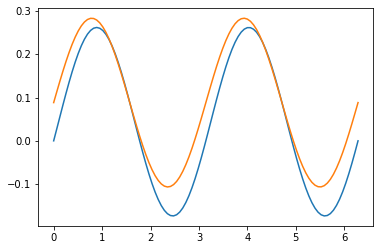

In [812]:
gamma_2s = np.linspace(0, 2*pi, 100)
plt.plot(gamma_2s, [-0.5*appendixc(pi/8, g, pi/8, pi/8) for g in gamma_2s])
plt.plot(gamma_2s, [qaoa2(pi/8, g, pi/8, pi/8, 2).real-0.5 for g in gamma_2s])

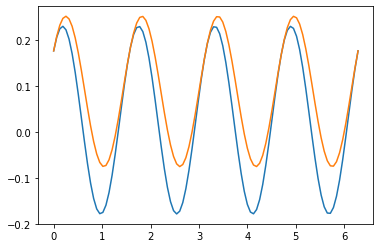

In [806]:
beta_2s = np.linspace(0, 2*pi, 100)
plt.plot(beta_2s, [-0.5*appendixc(b, pi/8, pi/8, pi/8) for b in beta_2s])
plt.plot(beta_2s, [qaoa2(b, pi/8, pi/8, pi/8, 2).real-0.5 for b in beta_2s])

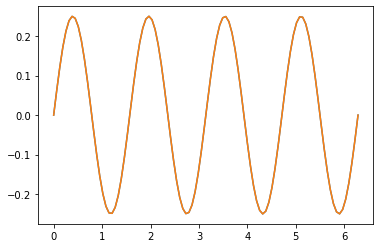

In [807]:
beta_1s = np.linspace(0, 2*pi, 100)
plt.plot(beta_1s, [-0.5*appendixc(0, 0, b, pi/4) for b in beta_1s])
plt.plot(beta_1s, [qaoa2(0, 0, b, pi/4, 2).real-0.5 for b in beta_1s])

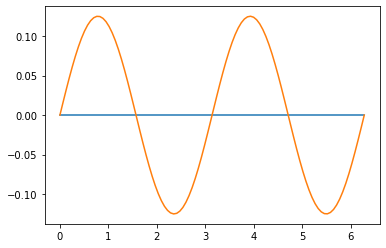

In [811]:
gamma_1s = np.linspace(0, 2*pi, 100)
plt.plot(gamma_1s, [-0.5*appendixc(pi/8, 0, pi/8, g) for g in gamma_1s])
plt.plot(gamma_1s, [qaoa2(pi/8, 0, pi/8, g, 2).real-0.5 for g in gamma_1s])

## Qaoa 2 formula (both appendix c and mine) collapses to qaoa1 formula if beta_1 = 0, gamma_1 = 0 or beta_2, gamma_2 = 0,0

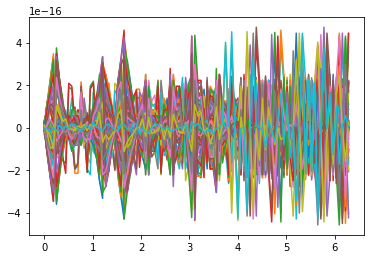

In [786]:
# works ok for ring formula
for b in beta_1s:
    plt.plot(gamma_1s, [delta_triangles(b, g, 2, 0)- (-0.5*appendixc(b, g, 0, 0)) for g in gamma_1s], label="beta_1=" + str(b))

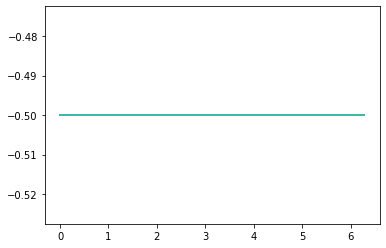

In [787]:
for b in beta_1s:
    plt.plot(gamma_1s, [delta_triangles(b, g, 2, 0)-qaoa2(b, g, 0, 0, 2).real for g in gamma_1s], label="beta_1=" + str(b))

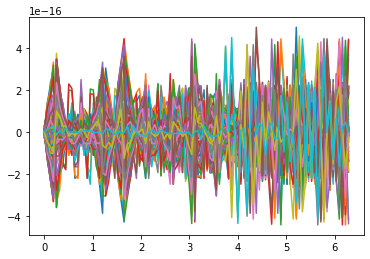

In [788]:
# works ok for ring formula
for b in beta_1s:
    plt.plot(gamma_1s, [delta_triangles(b, g, 2, 0)- (-0.5*appendixc(0, 0, b, g)) for g in gamma_1s], label="beta_1=" + str(b))

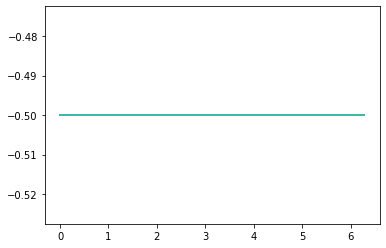

In [789]:
for b in beta_1s:
    plt.plot(gamma_1s, [delta_triangles(b, g, 2, 0)-qaoa2(0, 0, b, g, 2).real for g in gamma_1s], label="beta_1=" + str(b))

# TODO  from here
* replace i idx variable in eqwuations with j or some4thing else
* doits with \cdots
* need new variable name for D -> E

Need to code this expression up, and plot across the 8 variables...

## todo - Optimizations
* Memoize results in cuv triangles so it only takes a long time to run once


## todo - Analytical result
* Could try to solve optimal value analytically for f=1, or f=2, etc?
* Could try to solve optimal value generally for f?

$$
〈Cuv〉(d,f)  =1/2+1/2sin 4βsinγ(cos^dγ)−1/4sin^2βcos^{2(d−f)}γ(1−cos^f2γ)
$$


## todo - Comparison with Hastings + triangles
started july 10
* it looks like Hastings does worse with many triangles, or at least takes a high D to catch up. Verify this. Why might this be?
* one triangle to one triangle, Hastings catches up by D=20-30.
* two triangles to two triangles, Hastings catches up by D=60-75.
* maybe, in limit of D, Hastings will win, but with many triangles, Hastings algorithm is not that good?
    * it makes sense. Hastings depends on the $E_{ij}$ having an impact on modifying $i$ but not $j$, or vice versa. If many neighbors are shared, it limits the impact of $E_{ij}$ being in the max cut (i.e. $i$ and $j$ being differently colored).

In [7]:
# if beta = pi/8, then the last term has this much weight compared to the triangle-free term
sin(pi/8)**2/2

0.07322330470336312

In [8]:
def test(x, d, f):
    """something to find the max of"""
    return sin(x) * cos(x)**d - .073* cos(x)**(2*d-2*f) * (1 - cos(2*x)**f)

0.15407211396280857 cot^2(gamma): 15.034609765779608
0.1503758142939567 cot^2(gamma): 15.034609765779608
0.14668016666400788 cot^2(gamma): 15.130442693719809
0.14296930832566226 cot^2(gamma): 15.130442693719809
0.13922845634952807 cot^2(gamma): 15.227156491516158
0.13544356248562403 cot^2(gamma): 15.42327015835377
0.1316021187021014 cot^2(gamma): 15.623039376023863
0.127695432523486 cot^2(gamma): 15.826555523267764
0.12371926542290256 cot^2(gamma): 16.245208598052272
0.1196756002129015 cot^2(gamma): 16.68001988102886
0.11557503917375125 cot^2(gamma): 17.364390380878994
0.11143694061245829 cot^2(gamma): 18.215310855763693
0.10728986831771681 cot^2(gamma): 19.26372604340221
0.103168733504168 cot^2(gamma): 20.551116496977574
0.09911159426621666 cot^2(gamma): 21.96746648471558


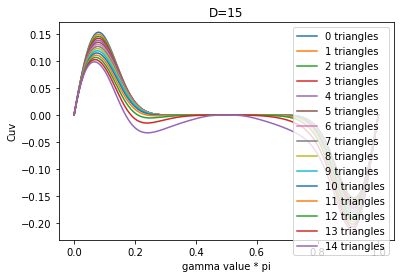

In [9]:
d=15
for f in range(d):
    inputs = np.linspace(0,pi, 4096)
    outputs = [test(x, d, f) for x in inputs]
    plt.plot(inputs/pi, outputs, label=str(f) + " triangles")
    print(max(outputs), "cot^2(gamma):", np.tan(inputs[outputs.index(max(outputs))])**-2)
plt.xlabel("gamma value * pi")
plt.ylabel("Cuv")
plt.title('D=' + str(d))
plt.legend()

Assuming Beta = pi/8, the maximum gamma value does not change by much, but it does get slightly less with more triangles.